# MIDTERM: PARAMETER ESTIMATION

# Questions

In this homework, you will do a parameter estimation for
BioModels model 45.

1. (10 pts) **Acquire the Model**. Create a roadrunner instance of the model and print the antimony representation of the model in an output cell.

1. (20 pts) **Data Generation**. Create synthetic data for the floating species using the values of the parameter in the published model:
   1. (10 pts) Create 3 sets of synthetic data for standard deviations of 0.1, 0.2, and 0.5.
   1. (10 pts) Plot the three datatsets. What characteristics of the data confirm that these synthetic data
   are consistent with your expectations.
   
1. (40 pts) **Experiment Infrastructure**. Implement the following functions:

    1. ``generateNoisyData``: Creates noisy versions of the simulation floating species. Inputs are antimony model and stadard deviation of noise; outputs are SBstoat.NamedTimeseries.
    1. ``doFit``: Encapsulates the fitting and evaluation workflow. Inputs are: antimony model, standard deviation of noise, the fitting method, and fractions of the true value for: lower end of parameter search, starting value of parameter search, and upper end of parameter search; Outputs are: residual sum of squares of the fit and the number of function evaluations (see ``getFitInfo`` in Helper Functions).
    **Don't forget to document your functions and include tests. All tests must have at least one ``assert``**

   
1. (30 pts) **Experiments and Analysis**.
Use the experiment infrastructure to determine of effects of: standard deviation of noise,
search range, and search algorithm. You want to understand the impact on accuracy of parameter estimates and the time to do the parameter estimation. We will quantify accuracy in terms of residual sum of square, and time is in units of function evaluations.

    A. (20 pts) Plot the results. All experiments should set the starting value of the search
to the lower end of the range.
        1. Use the standard deviations of noise: 0.1, 0.2, 0.5
        1. Use the search ranges lower_frc, upper_frc = (0.5, 2.0) and (0.25, 4.0)
        1. Use the search algorithms ``leastsquares`` and ``differential_evolution``
   
   Construct plots as follows:
   
        1. x-axis: number of function evaluations
        2. y-axis: residual sum of squares
        3. Separate lines for each standard deviation
    You will have 4 such plots.
    
   B. (10 pts) Explain the results.

**Please do your homework in a copy of this notebook, maintaining the sections.**

# Programming Preliminaries
This section provides the setup to run your python codes.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SBstoat
import tellurium as te

## Constants

In [2]:
ENDTIME = 60
NUMPOINT = 1200
STDS = [0.1, 0.2, 0.5]

# Helper Functions

In [3]:
TEST_MODEL = """
A->B; A
B->; k*B; 
A = 10; 
B=0
k = 2
"""
TEST_MODEL_RR = te.loada(TEST_MODEL)
TEST_MODEL_ARR = TEST_MODEL_RR.simulate()
TEST_MODEL_TS = SBstoat.NamedTimeseries(array=TEST_MODEL_ARR, colnames=TEST_MODEL_ARR.colnames)

In [4]:
def arrToDF(arr):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    df = df.set_index("time")
    return df

# Tests
assert(isinstance(arrToDF(TEST_MODEL_ARR), pd.DataFrame))
print("OK!")

OK!


In [5]:
def getFitInfo(fitter):
    """
    Calculates the residuals sum of squares of a fitted model and the number of function evaluations.
    
    Parameters
    ----------
    fitter: SBstoat.ModelFitter
    
    Returns
    -------
    float (sum of squares of the residuals of the fit)
    """
    df = (fitter.residualsTS.to_dataframe()**2)
    rssq = df.sum().sum()
    # Find the number of function evaluations
    report_stg = fitter.reportFit()
    pos = report_stg.index("function evals")
    stg = report_stg[pos:]
    start_pos = stg.index("=") + 1
    end_pos = stg.index("\n")
    num_eval = int(stg[start_pos:end_pos])
    #
    return rssq, num_eval
    

# Tests
fitter = SBstoat.ModelFitter(TEST_MODEL, TEST_MODEL_TS, parametersToFit=[SBstoat.Parameter("k", lower=1, value=1, upper=4)])
fitter.fitModel()
rssq, num_eval = getFitInfo(fitter)
assert(np.isclose(rssq, 0))
assert(num_eval < 10)
print("OK!")

OK!


# Question 1: Acquire the model

In [6]:
MODEL_RR = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000045.2?filename=BIOMD0000000045_url.xml")
MODEL_ARR = MODEL_RR.simulate()
MODEL_ANT = MODEL_RR.getAntimony()
print(MODEL_ANT)

// Created by libAntimony v2.13.2
model *Goldbeter_Calcium_Oscillation_based_onCICR_AND_two_pool_model()

  // Compartments and Species:
  compartment extracellular, cytosol, intravesicular1, intravesicular2;
  species EC in extracellular, Z in cytosol, Y in intravesicular2, X in intravesicular1;

  // Reactions:
  vin: EC => Z; cytosol*(vin_v0 + vin_v1*beta);
  v2i: Z => Y; intravesicular2*v2i_Vm2i*Z^2/(v2i_K2i^2 + Z^2);
  v3i: Y => Z; cytosol*v3i_Vm3i*Y^2*Z^2/((v3i_K3y^2 + Y^2)*(v3i_K3z^2 + Z^2));
  v4: Y => Z; cytosol*v4_Kf*Y;
  v5: Z => EC; extracellular*v5_K*Z;
  v6: X => Z; cytosol*v6_Kf*X;
  v2s: Z => X; intravesicular1*v2s_Vm2s*Z^2/(v2s_K2s^2 + Z^2);
  v3s: X => Z; cytosol*beta*v3s_Vm3s*X^2/(v3s_K3s^2 + X^2);

  // Species initializations:
  EC = 0;
  Z = 0;
  Y = 0;
  X = 0.5;

  // Compartment initializations:
  extracellular = 1;
  cytosol = 1;
  intravesicular1 = 1;
  intravesicular2 = 1;

  // Variable initializations:
  beta = 1;
  vin_v0 = 0.015;
  vin_v1 = 0.012;
  v2i_

# Question 2: Data Generation

In [7]:
def generateNoisyData(std, model=MODEL_ANT, is_plot=True):
    """
    Generates noise columns in a dataframe.
    
    Parameters
    ----------
    std: float (standard deviation of generated noise)
    model: str (antimony model)
    is_plot: bool (plot the noise)
    
    Returns
    -------
    NamedTimeseries
    """
    rr = te.loada(model)
    data = rr.simulate()
    df = arrToDF(data)
    normalization_ser = df.mean()
    # Use the input DataFrame as a template
    noise_df = df.copy()
    # Create the noise data
    for column in noise_df.columns:
        noise_arr = np.random.normal(0, std, len(noise_df))
        noise_df[column] = normalization_ser.loc[column]*noise_arr 
    if is_plot:
        _, ax = plt.subplots(1)
        for column in noise_df.columns:
            ax.scatter(noise_df.index, noise_df[column])
        plt.legend(noise_df.columns)
        plt.title("Generated Noise. Std=%2.2f" % std)
    data_df = df + noise_df
    return SBstoat.NamedTimeseries(dataframe=data_df)
                  
# Tests
df = generateNoisyData(0.5, is_plot=False)
assert(isinstance(df, SBstoat.NamedTimeseries))
print("OK!")

OK!


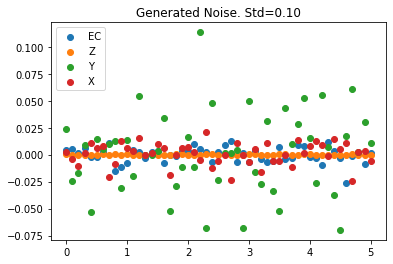

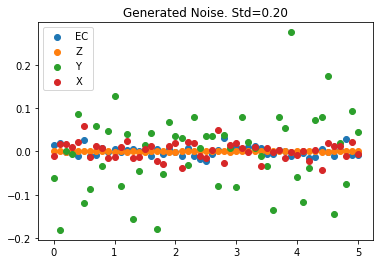

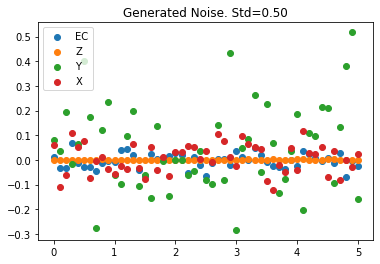

In [8]:
DATA_DCT = {}
for std in STDS:
    DATA_DCT[std] = generateNoisyData(std)

# Question 3: Experiment Infrastructure

In [9]:
# Dictionary representation of the parameters and their values
PARAMETER_DCT = {"beta": 1, "vin_v0": 0.015, "vin_v1": 0.012,
       "v2i_Vm2i": 3.1, "v2i_K2i": 0.005,
      "v3i_Vm3i": 25, "v3i_K3y": 0.065, "v3i_K3z": 0.022, "v4_Kf": 0.5,
       "v5_K": 1, "v6_Kf": 0.5, "v2s_Vm2s": 1.5, "v2s_K2s": 0.0265,
       "v3s_Vm3s": 0.169, "v3s_K3s": 0.1,
      }

def getParameters(parameter_dct=PARAMETER_DCT, lower_frc=1.0, value_frc=1.0, upper_frc=1.0):
    """
    Constructs the list of parameters for for the model.
    
    Parameters
    ----------
    parameter_dct: dict (key: name, value: parameter value)
    lower_frc: float (fraction used to calculate lower range of search. Should be in [0, 1.0])
    value_frc: float (fraction used to calculate start of search. lower_frc <= value_frc <= upper_frc)
    upper_frc: float (fraction used to calculate upper limit of search. Should be in [value_frc, inf])
    
    Returns
    -------
    list-SBstoat.Parameter
    """
    parameters = []
    for key, true_value in parameter_dct.items():
        lower = lower_frc*true_value
        value = value_frc*true_value
        upper = upper_frc*true_value
        parameter = SBstoat.Parameter(key, lower=lower, value=value, upper=upper)
        parameters.append(parameter)
    return parameters

# Tests
parameter_dct = {"k1": 1, "k2": 2}
parameters = getParameters(parameter_dct=parameter_dct, lower_frc=0.5, value_frc=0.8, upper_frc=2.0)
assert(len(parameters) == 2)
assert(isinstance(parameters[0], SBstoat.Parameter))
assert(parameters[0].lower == 0.5)
assert(parameters[0].value == 0.8)
assert(parameters[0].upper == 2.0)
print("OK!")

OK!


In [10]:
def doFit(model=MODEL_ANT,
          std=0.2,
          fitterMethods=["leastsq"], 
          lower_frc=0.5,
          value_frc=0.5,
          upper_frc=2.0,
          isReport=False):
    """
    Encapsulates the workflow to fit the linear pathway model.

    Parameters
    ----------
    selectedColumns: list-str
    endTime: int
    fitterMethods: list-str
    parametersToFit: list-SBstoat.Parameter
    isReport: bool
        Produce outputs

    Returns
    -------
    float (residual sum of squares), int (number of function evaluations)
    """
    parameters = getParameters(PARAMETER_DCT, lower_frc, value_frc, upper_frc)
    timeseries = generateNoisyData(std, model=model, is_plot=False)
    # Construct the fitter and do the fit
    fitter = SBstoat.ModelFitter(model, timeseries,
                         fitterMethods=fitterMethods, 
                         parametersToFit=parameters)
    fitter.fitModel()
    if isReport:
        print(fitter.reportFit())
        fitter.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"],
                          titlePosition=(0.5, 1.05))
    return getFitInfo(fitter)

# TESTS
rssq, num_eval = doFit(isReport=False, std=0.2, fitterMethods=["leastsquares"],
              lower_frc=0.5, value_frc=0.5, upper_frc=2.0)
assert(rssq < 5)
assert(num_eval > 0 and num_eval < 500)
print("OK")

OK


In [13]:
STDS

[0.1, 0.2, 0.5]

# Question 4: Experiment Execution and Analysis

In [24]:
def makePlot(model=MODEL_ANT, method="leastsquares", search_range=2, stds=STDS):
    """
    Creates a results plot for the specified parameters.
    
    Parameters
    ----------
    method: str (optimization method)
    search_range: float (size of the search range for the fit)
    """
    STD = "std"
    RSSQ = "rssq"
    NUM_EVAL = "num_eval"
    # Initializations
    lower_frc = 1/search_range
    value_frc = lower_frc
    upper_frc = search_range
    # Obtain the fitter results
    result_dct = {n: [] for n in [STD, RSSQ, NUM_EVAL]}
    for std in STDS:
        rssq, num_eval = doFit(model=MODEL_ANT, std=std, fitterMethods=[method], lower_frc=lower_frc,
              value_frc=value_frc, upper_frc=upper_frc, isReport=False)
        result_dct[STD].append(std)
        result_dct[RSSQ].append(rssq)
        result_dct[NUM_EVAL].append(num_eval)
    return pd.DataFrame(result_dct)

# Tests
makePlot()
    
        

,std,rssq,num_eval
0,0.1,0.138748,179
1,0.2,2.111423,191
2,0.5,2.228141,159
